In [55]:
import os
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
from torchvision import transforms
import torchvision.models as models
from imutils import paths


In [56]:
print(os.getcwd())

/Users/noahbaker/Mask_Detection


In [ ]:
preprocess = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [58]:
path = list(paths.list_images("Dataset"))

In [59]:
mask_map = {
    'without_mask' : 0,
    'with_mask': 1,
    'mask_weared_incorrect': 2
}

mask_tensor = []
labels = []
for image_path in path:
    label = image_path.split(os.path.sep)[-2]
    im = Image.open(image_path ).convert('RGB')

    if im is None:
        print("Error: Could not load image.")
        exit()

    input_tensor = preprocess(im)
    labels.append(label)
    mask_tensor.append(input_tensor)


encoded_labels = [mask_map[label] for label in labels]
print(len(mask_tensor))
    

8982


In [60]:
print(label[5])

u


In [61]:
X_train, X_test, y_train, y_test = train_test_split(mask_tensor, encoded_labels, test_size=0.2, random_state=1, stratify=encoded_labels)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) 

In [62]:
class dataset():
    def __init__(self, vector, label):
        self.vector = vector #torch.Size([3, 224, 224])
        self.label = torch.tensor(label, dtype = torch.long) #single int!!!  0: w/o mask, 1: with mask, 2: mask work incorrectly

    def __len__(self):
        return len(self.vector)
    
    def __getitem__(self,index):
        return self.vector[index], self.label[index]

In [63]:
trainSet = dataset(X_train, y_train)
validSet = dataset(X_val, y_val)
testSet = dataset(X_test, y_test)

batches = 32

train_dl = DataLoader(trainSet, batch_size=batches, shuffle=True, drop_last=True)
valid_dl = DataLoader(validSet, batch_size=batches, drop_last=True)
test_dl = DataLoader(testSet, batch_size=batches, drop_last=True)

In [64]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=3)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [65]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3) #momentum and weight decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

In [66]:
def train(Dataloader, model, loss_fn, optimizer):
    model.train()
    total_acc, total_loss = 0,0
    for vector, label in Dataloader:
        optimizer.zero_grad()
        pred = model(vector)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_acc += ((pred.argmax(1) == label).type(torch.float).sum().item())
        total_loss += loss.item() * label.size(0)
    return total_acc/len(Dataloader.dataset), total_loss/len(Dataloader.dataset)


def evaluate(Dataloader, model, loss_fn):
    model.eval()
    total_acc, total_loss = 0,0
    with torch.no_grad():
        for vector, label in Dataloader:
            pred = model(vector)
            loss = loss_fn(pred, label)
            total_acc += ((pred.argmax(1) == label).type(torch.float).sum().item())
            total_loss += loss.item() * label.size(0)
    return total_acc/len(Dataloader.dataset), total_loss/len(Dataloader.dataset)

In [67]:
history = {
    "train_acc": [],
    "val_acc": [],
    "train_loss": [],
    "val_loss": []
}
epochs = 10

for epoch in range(epochs):
    acc_train, loss_train = train(train_dl, model, loss_fn, optimizer)
    acc_val, loss_val = evaluate(valid_dl, model, loss_fn)
    scheduler.step()
    
    history["train_acc"].append(acc_train)
    history["val_acc"].append(acc_val)
    history["train_loss"].append(loss_train)
    history["val_loss"].append(loss_val)

    print(f'Epoch {epoch} accuracy: {acc_train:.4f}    val_accuracy: {acc_val:.4f}    val_loss: {loss_val:.4f}')

Epoch 0 accuracy: 0.8194    val_accuracy: 0.9054    val_loss: 0.2666
Epoch 1 accuracy: 0.8976    val_accuracy: 0.9032    val_loss: 0.2338
Epoch 2 accuracy: 0.8996    val_accuracy: 0.9065    val_loss: 0.2177
Epoch 3 accuracy: 0.9087    val_accuracy: 0.9215    val_loss: 0.1888
Epoch 4 accuracy: 0.9109    val_accuracy: 0.9254    val_loss: 0.1864
Epoch 5 accuracy: 0.9222    val_accuracy: 0.9271    val_loss: 0.1787
Epoch 6 accuracy: 0.9232    val_accuracy: 0.9288    val_loss: 0.1731
Epoch 7 accuracy: 0.9215    val_accuracy: 0.9316    val_loss: 0.1706
Epoch 8 accuracy: 0.9230    val_accuracy: 0.9310    val_loss: 0.1780
Epoch 9 accuracy: 0.9274    val_accuracy: 0.9327    val_loss: 0.1655


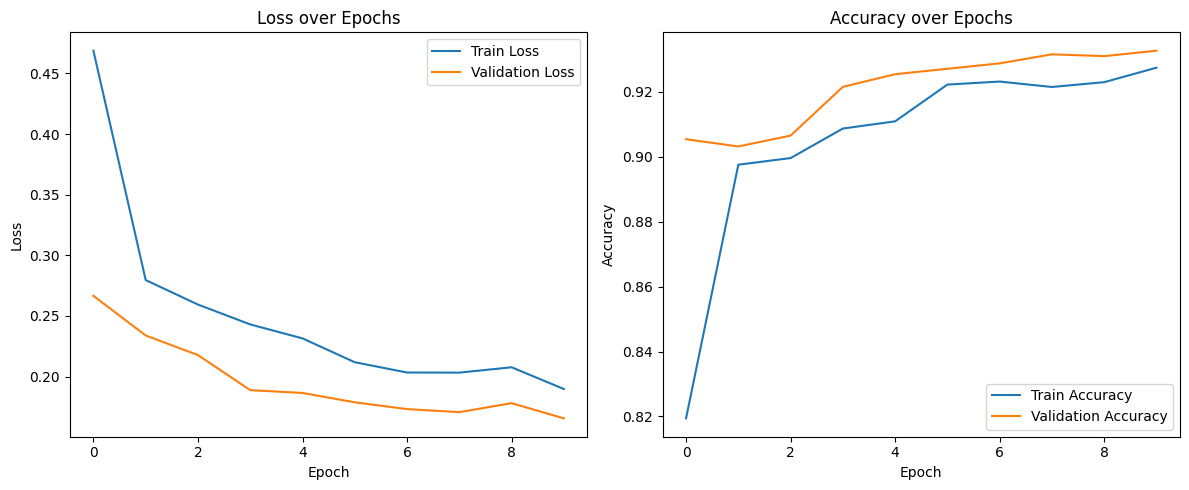

In [71]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [72]:
acc_test , _ = evaluate(test_dl, model, loss_fn)
print(f'Test Accuracy: {acc_test:.4f}')

Test Accuracy: 0.9371


In [75]:
import copy
model_wts = copy.deepcopy(model.state_dict())
torch.save(model, 'mask-model-new.pth')